In [1]:
import itertools
import sys
from pathlib import Path

import h5py as h5
import numpy as np
import pandas as pd

sys.path.append('../lib')
from storage import get_storage_functions
from local_paths import preproc_dir, analysis_dir
from self_consistency import pairwise_self_consistency_perm_test

# Set parameters

In [2]:
#============================================================================
# session
#============================================================================
sess_name = 'sess_name'


#============================================================================
# response windows
#============================================================================
t_pre  = 375
t_post = 375
t_step =  10


#============================================================================
# statistical tests
#============================================================================
match_tests = (('current', 'previous', 'greater'),)
n_perm = 10000
save_perm_diffs = False  # whether to save permuted delta effect sizes


#============================================================================
# paths
#============================================================================
proc_dir = preproc_dir
sdf_dir = preproc_dir
sdf_suffix = '-mwa_50'

rsc_dir = analysis_dir + 'self_consistency_no_decorr'

output_dir = analysis_dir + 'self_consistency_match_control'

In [3]:
# Parameters
sess_name = "Pa210201"
output_dir = "../test_results"


# Check prereqs and params

In [4]:
proc_path = Path(proc_dir) / (sess_name + '-proc.h5')
print('Loading shared processing from', proc_path)
proc_path = proc_path.expanduser()
assert proc_path.is_file()

rsc_path = Path(rsc_dir) / (sess_name + '.h5')
print('Loading return fixation self-consistency results from', rsc_path)
rsc_path = rsc_path.expanduser()
assert rsc_path.is_file()

sdf_path = Path(sdf_dir) / (sess_name + f'-sdf{sdf_suffix}.h5')
print('Loading spike density function from', sdf_path)
sdf_path = sdf_path.expanduser()
assert sdf_path.is_file()

output_dir = Path(output_dir)
assert output_dir.expanduser().is_dir()
output_path = output_dir / (sess_name + '.h5')
print('Saving results to', output_path)
output_path = output_path.expanduser()

Loading shared processing from ../test_data/Pa210201-proc.h5
Loading return fixation self-consistency results from ../test_results/self_consistency_no_decorr/Pa210201.h5
Loading spike density function from ../test_data/Pa210201-sdf-mwa_50.h5
Saving results to ../test_results/Pa210201.h5


In [5]:
analysis_name = 'self_consistency_match_control'

if output_path.is_file():
    with h5.File(output_path, 'r') as f:
        try:
            if f[f'progress_report/{analysis_name}/all_done'][()].item():
                raise RuntimeError(f'{sess_name} has already been processed')
        except KeyError:
            pass

In [6]:
assert len(match_tests) and n_perm

# Save config

In [7]:
with h5.File(proc_path, 'r') as f:
    random_seed = f['config/default_random_seed'][()]
print('random_seed:', random_seed)

random_seed: 775418045


In [8]:
with h5.File(rsc_path, 'r') as f:
    return_thres = f['self_consistency/config/return_criterion/return_thres'][()]
    sacc_sel = f['self_consistency/saccade_selection'][()]  # shape (2, nsacc)

In [9]:
save_results, add_attr_to_dset, check_equals_saved, link_dsets, copy_group = \
    get_storage_functions(output_path)

In [10]:
group = analysis_name + '/config/'
save_results(group+'random_seed', random_seed)

group = analysis_name + '/config/time_windows/'
save_results(group+'t_pre', t_pre)
save_results(group+'t_post', t_post)
save_results(group+'t_step', t_step)
add_attr_to_dset(group, attrs=dict(unit='ms'))

group = analysis_name + '/config/return_criterion/'
save_results(group+'return_thres', return_thres, attrs=dict(unit='dva'))

group = analysis_name + '/config/statistics/'
save_results(group+'tests', str(match_tests))
save_results(group+'test_kind', 'permutation')
save_results(group+'n_perm', n_perm)

save_results(analysis_name + '/saccade_selection', sacc_sel)

# Find matches for return pairs

In [11]:
fix_df = pd.read_hdf(proc_path, 'fixation_dataframe', 'r')

In [12]:
bycond_return_pairs = {}
with h5.File(rsc_path, 'r') as f:
    group = f['self_consistency/return_pairs']
    for k, v in group.items():
        v = v[()]
        if not v.size: continue
        v = np.sort(v, axis=1)
        v = v[np.lexsort(tuple(v.T))]
        bycond_return_pairs[k] = v

In [13]:
sacc_vecs = np.array([  # shape (n_sacc, 2, 2)
    fix_df.iloc[sacc_sel[i]][['Relative X', 'Relative Y']].values
    for i in range(2)]).transpose(1,0,2)

In [14]:
matched_return_pairs = {}

for match_test in match_tests:
    src_cond, dst_cond, alternative = match_test
    src_pairs = bycond_return_pairs[src_cond]
    dst_pairs = bycond_return_pairs[dst_cond]

    # do both fixations in src match something in dst?
    src_pairs_df = pd.DataFrame(src_pairs)
    matched = src_pairs_df.isin(np.unique(dst_pairs)).values.all(1)

    # chose a match for each fixation in a matched src pair
    rg = np.random.default_rng(random_seed)
    match_pairs = np.empty_like(src_pairs, shape=(matched.sum(), 2))
    match_pairs_mask = np.ones(matched.sum(), dtype=bool)
    src_pairs_set = set(map(tuple,src_pairs))
    for im, (i, pair) in enumerate(zip(np.nonzero(matched)[0], src_pairs[matched])):

        # find all match options
        i0s = np.nonzero((dst_pairs == pair[0]).any(1))[0]
        i1s = np.nonzero((dst_pairs == pair[1]).any(1))[0]

        # choose one randomly
        rg.shuffle(i0s)
        rg.shuffle(i1s)
        found = False
        for i0, i1 in itertools.product(i0s, i1s):
            m0 = (set(dst_pairs[i0]) - {pair[0]}).pop()
            m1 = (set(dst_pairs[i1]) - {pair[1]}).pop()
            if m0 == m1 or tuple(sorted((m0, m1))) in src_pairs_set:
                continue
            if dst_cond in ('previous', 'current'):
                ic = int(dst_cond == 'current')
                sep_src = np.linalg.norm(sacc_vecs[pair[0],ic]-sacc_vecs[pair[1],ic], axis=-1)
                sep_match = np.linalg.norm(sacc_vecs[m0,ic]-sacc_vecs[m1,ic], axis=-1)
                if sep_src < sep_match: continue
            if src_cond in ('previous', 'current'):
                ic = int(src_cond == 'current')
                sep = np.linalg.norm(sacc_vecs[m0,ic]-sacc_vecs[m1,ic], axis=-1)
                if sep <= return_thres: continue
            match_pairs[im] = m0, m1
            found = True
            break

        if not found:
            match_pairs_mask[im] = False
            matched[i] = False

    assert matched.sum() == match_pairs_mask.sum()
    match_pairs = match_pairs[match_pairs_mask]

    matched_return_pairs[f'{src_cond}_matched_{dst_cond}'] = src_pairs[matched]
    matched_return_pairs[f'{src_cond}_match_{dst_cond}'] = match_pairs

In [15]:
for k, v in matched_return_pairs.items():
    print(k, v.shape)

current_matched_previous (158, 2)
current_match_previous (158, 2)


In [16]:
group = analysis_name + '/matched_return_pairs/'
for cond, pairs in matched_return_pairs.items():
    if not pairs.size:
        pairs = h5.Empty('i')
    save_results(group+cond, pairs)

# Get fixation onset-aligned responses

In [17]:
with h5.File(sdf_path, 'r') as f:
    dset = f['sdf']
    unit_names = dset.attrs['unit_names'].astype(str)
    sdf = dset[()]
    if 'unit_names' in f:
        copy_group(f, 'unit_names', analysis_name+'/unit_names')

n_neur = sdf.shape[1]
unit_names.shape, unit_names.dtype, sdf.shape, sdf.dtype

((92,), dtype('<U3'), (6234150, 92), dtype('float32'))

In [18]:
ts = np.arange(-t_pre, t_post, t_step)

resps = np.empty_like(sdf, shape=(sacc_sel.shape[1], ts.size, sdf.shape[-1]))
for i, t in enumerate(fix_df.iloc[sacc_sel[1]]['Time'].values):
    ts_ = np.round(t+ts).astype(int)
    resps[i] = sdf[ts_,:]

resps.shape, resps.dtype

((4037, 75, 92), dtype('float32'))

# Permutation test

In [19]:
test_results = {}
coords = (('time', ts), ('unit', unit_names))
attrs = dict(random_seed=random_seed, sdf_suffix=sdf_suffix)

for match_test in match_tests:
    print('test:', match_test)

    src_cond, dst_cond, alternative = match_test
    cond0 = f'{src_cond}_matched_{dst_cond}'
    cond1 = f'{src_cond}_match_{dst_cond}'
    pairs0 = matched_return_pairs[cond0]
    pairs1 = matched_return_pairs[cond1]

    try:
        ds = pairwise_self_consistency_perm_test(
            resps=resps,
            pairs0=pairs0,
            pairs1=pairs1,
            paired=True,
            alternatives=alternative,
            n_permutations=n_perm,
            random_seed=random_seed,
            coords=coords,
            attrs=attrs,
            verbose=True)
    except ValueError as e:
        if 'Less than 2 pairs' in str(e):
            continue
        raise

    test_results[(src_cond, cond1)] = ds
    print()

test: ('current', 'previous', 'greater')
calculating self consistency permutation distribution w.r.t. pairing conditions
10000 permutations


done (48.8 s)



In [20]:
group = analysis_name + '/permutation_test/'
compr = dict(zlib=True, complevel=9)
for (c0, c1), dataset in test_results.items():
    if not save_perm_diffs:
        dataset = dataset.drop_vars('permuted_diffs')
    encoding = {
        k: dict(chunksizes=v.shape, **compr)
        for k, v in dataset.data_vars.items()
        if v.size}
    dataset.to_netcdf(
        output_path, group=group+f'{c0}_v_{c1}',
        mode='a', engine='h5netcdf', encoding=encoding)

# Wrap up

In [21]:
save_results(f'progress_report/{analysis_name}/all_done', True)

In [22]:
%load_ext watermark
%watermark
%watermark -vm --iversions -rbg

Last updated: 2024-02-18T14:22:48.260686-05:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.0-92-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.0-92-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Git hash: b0bb10f45dee065cc3af96fe224326b883d27431

Git repo: https://github.com/willwx/free_viewing_staging.git

Git branch: master

h5py  : 3.8.0
numpy : 1.24.3
sys   : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
pandas: 2.0.1



# Plots

In [23]:
import matplotlib.pyplot as plt

Fixation 1, x - y:
count    158.000000
mean       0.452757
std        0.394074
min        0.003311
25%        0.142085
50%        0.358897
75%        0.613794
max        1.723348
dtype: float64

Fixation 2, x - y:
count    158.000000
mean      -4.458199
std        3.076117
min      -12.622072
25%       -6.451844
50%       -4.033486
75%       -1.785360
max       -0.117269
dtype: float64



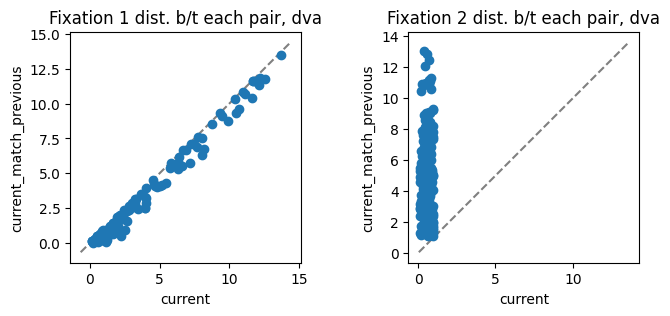

In [24]:
for match_test in match_tests:
    src_cond, dst_cond, alternative = match_test
    cond1 = f'{src_cond}_match_{dst_cond}'
    pairs0 = matched_return_pairs[cond0]
    pairs1 = matched_return_pairs[cond1]
    fig, axs = plt.subplots(1, 2, figsize=(8,3))
    for i, ax in enumerate(axs):
        ds = np.linalg.norm(sacc_vecs[pairs0[:,0],i] - sacc_vecs[pairs0[:,1],i], axis=-1)
        mds = np.linalg.norm(sacc_vecs[pairs1[:,0],i] - sacc_vecs[pairs1[:,1],i], axis=-1)
        ax.scatter(ds, mds)
        lims = np.array([ax.get_xlim(), ax.get_ylim()])
        lim = lims[:,0].min(), lims[:,1].max()
        ax.plot(lim, lim, color='gray', zorder=-1, ls='--')
        ax.set_aspect('equal')
        ax.set_title(f'Fixation {i+1} dist. b/t each pair, dva')
        ax.set_xlabel(src_cond)
        ax.set_ylabel(cond1)
        print(f'Fixation {i+1}, x - y:')
        print(pd.Series(ds-mds).describe())
        print()

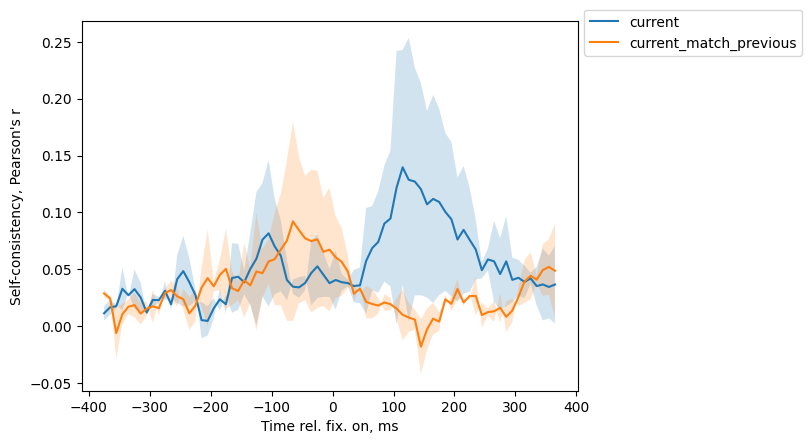

In [25]:
for test, results in test_results.items():
    src_cond, cond1 = test
    ds = results
    plt.figure()
    for k, n in zip(('cond0', 'cond1'), (src_cond, cond1)):
        m = np.nanmean(ds[k], -1)
        s = np.nanmedian(ds[k], -1)
        l, = plt.plot(ts, m, label=n)
        plt.fill_between(ts, m-s, m+s, ec='none', fc=l.get_color(), alpha=0.2)
    plt.xlabel('Time rel. fix. on, ms')
    plt.ylabel('Self-consistency, Pearson\'s r')
    plt.legend(loc='upper left', bbox_to_anchor=(1,1.05))

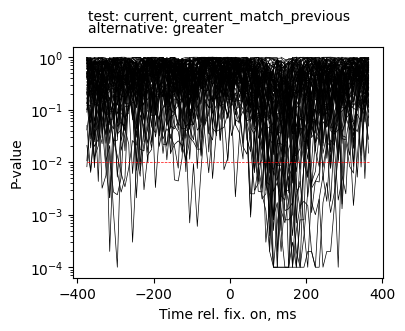

In [26]:
for test, results in test_results.items():
    alts = results.coords['alternative'].values
    n = len(alts)
    fig, axs = plt.subplots(1, n, figsize=(4*n,3), squeeze=False, sharex=True)
    plt.subplots_adjust(wspace=0.5)
    f = lambda x: x if isinstance(x, str) else ', '.join(map(str, x))
    pvals_ = results['p-value'].values
    for i, ax in enumerate(axs.ravel()):
        vs = pvals_[i]
        ax.plot(ts, vs, c='k', lw=0.5);
        ax.set_yscale('log')
        ax.hlines(1e-2, ts.min(), ts.max(), ls='--', lw=0.5, color='r')
        ax.text(.05, 1.05, f'alternative: {alts[i]}',
                ha='left', va='bottom', transform=ax.transAxes)
    ax = axs[0,0]
    ax.text(.05, 1.1, 'test: '+', '.join(map(f, test)),
            ha='left', va='bottom', transform=ax.transAxes)
    axs[-1,0].set_xlabel('Time rel. fix. on, ms')
    axs[0,0].set_ylabel('P-value');

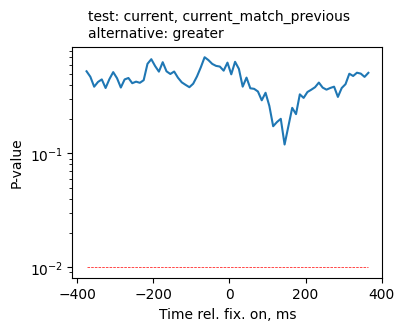

In [27]:
for test, results in test_results.items():
    alts = results.coords['alternative'].values
    n = len(alts)
    fig, axs = plt.subplots(1, n, figsize=(4*n,3), squeeze=False, sharex=True)
    plt.subplots_adjust(wspace=0.5)
    f = lambda x: x if isinstance(x, str) else ', '.join(map(str, x))
    pvals_ = results['p-value'].values
    for i, ax in enumerate(axs.ravel()):
            vs = pvals_[i]
            ax.plot(ts, np.nanmedian(vs, axis=-1))
            ax.set_yscale('log')
            ax.hlines(1e-2, ts.min(), ts.max(), ls='--', lw=0.5, color='r')
            ax.text(.05, 1.025, f'alternative: {alts[i]}',
                    ha='left', va='bottom', transform=ax.transAxes)
    ax = axs[0,0]
    ax.text(.05, 1.1, 'test: '+', '.join(map(f, test)),
            ha='left', va='bottom', transform=ax.transAxes)
    axs[-1,0].set_xlabel('Time rel. fix. on, ms')
    axs[0,0].set_ylabel('P-value');